# Hardware and Software for Big Data MOD A Project: Sentiment140 Sentimental Analysis and Community Detection

#### Chiara Cangelosi, Francesco Stellato, Gianluca Notarangelo

## Libraries used

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import pickle

In [0]:
%python
%pip install wordcloud

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
from wordcloud import WordCloud
import PIL
import pip

In [0]:
%python
%pip install nltk

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
#from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/spark-3e612e64-b20b-4418-8750-e2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report


In [0]:
from collections import Counter
import plotly.express as px

In [0]:
%python
%pip install python-louvain networkx

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import networkx as nx
from community import community_louvain
import itertools

## Introduction

In this notebook we want to build a project aimed at showing the use of the Databricks framework to implement machine learning algorithms on big data sets. The data set that will be used is the sentiment140 data set, sourced from Kaggle at the following link: https://www.kaggle.com/datasets/kazanova/sentiment140/data. As the name implies, this data set is usually used to learn how to implement sentiment analysis. Sentiment analysis is the process of interpreting the sentiment associated to a body of natural text and, as such, it is a text classification technique in the field of Natural Language Processing (NLP). Natural Language Processing is a computer science field revolving around the idea that it is possible to build algorithms than make possible the analysis of natural language through computational means. Recent successes in this field are strictly linked to improvements in machine learning methods and neural networks in particular, that have made possible speech recognition, natural language understanding and generation as well as various kinds of text classification.

The practical importance of these progresses has been highlighted by the ever increasing use of NLP techniques in companies around the world, which take advantage of them to better understand market trends by aggregating the sentiments expressed by users on social media regarding specific companies, products or subjects. Also, they are vastly used to automatize a range of tasks like digitizing documents, automatic documents summarizations or creating tailored chatbots. In fact, modern chatbots fundamentally rely on the advances in the field of Natural Language Processing, with methods such as natural language understanding, language translation, text-to-image/video generation being the base on which this softwares are built.

## Data set description and loading

The sentiment140 data set is made up of about 1.58 million tweets. These have been labelled with a binary target variable on the base of the sentiment that they convey: 0 if negative and 4 if positive. This labeling has not been done by the authors of the data set manually, as this would have required a massive amount of time. Instead they used an automatic algorithm to scrape tweets from the website and classify them on the basis of positive or negative emoticons (like smiling or sad emoticons). Tweets with both positive and negative emoticons were discarded, as well as retweets (a user sharing another user tweets) and eventual copies of the same tweet, so as to not give too much influence to any single tweet.

![Emoticons](https://i.imgur.com/7iZnf1b.png)

Before starting the analysis, one should notice that the data set labels tweets as either negative or positive, with no neutral options. However, many tweets seem to be neutral more than positive or negative. This means that a fully accurate classifier isn't really obtainable as a number of the positive and negative tweets are actually neutral and are therefore forcedly classified as a 0 or a 4, lowering any model performance. A random selection of about 20 tweets showed that about 8 of these are actually neutral, that is 40% of the sample. Supposing that our model perfectly classifies the remaining 60% of tweets, and that the neutral 40% is randomly divided between positives and negatives, obtaining on average a 50% precision, we obtain that the maximum approximate precision a classifier can achieve based on this simplified analysis is about 80%. This was recognized as a limitation also by the authors of the original paper. Therefore, we hope that our analysis will reach a level close to this percentage.

### Data set preparation

A CSV file is imported and read into a pandas dataframe using pd.read_csv(), specifying the encoding='latin1' in order to ensure proper handling of special characters. 
It is read into a pandas dataframe because Pandas functions allow easier data manipulation.

In [0]:
df1 = pd.read_csv("/Workspace/Users/chiaracange@icloud.com/training.1600000.processed.noemoticon.csv", encoding='latin1')
df1.head()

0  ...  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
0  0  ...  is upset that he can't update his Facebook by ...                                                                  
1  0  ...  @Kenichan I dived many times for the ball. Man...                                                                  
2  0  ...    my whole body feels itchy and like its on fire                                                                   
3  0  ...  @nationwideclass no, it's not behaving at all....                                                                  
4  0  ...                      @Kwesidei not the whole crew                                                                   

[5 rows x 6 columns]

This function checks for missing values in a Pandas DataFrame and returns a summary of missing data in each column. Since all values are 0, there are no missing values in the dataset.

In [0]:
#check for missing values
def missing_value_of_data(df1):
    total=df1.isnull().sum().sort_values(ascending=False)
    percentage=round(total/ df1.shape[0]*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])


missing_value_of_data(df1)

Total  Percentage
0                                                       0         0.0
1467810369                                              0         0.0
Mon Apr 06 22:19:45 PDT 2009                            0         0.0
NO_QUERY                                                0         0.0
_TheSpecialOne_                                         0         0.0
@switchfoot http://twitpic.com/2y1zl - Awww, th...      0         0.0

We decided to rename the columns of the dataframe to meaningful names, making the dataset easier to work with. However, because our main goal is sentiment classification and to a lesser extent community detection, we removed the date and query columns that we didn't need.

In [0]:
#renaming the columns since they do not have proper names
df1.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df1.head()

sentiment  ...                                               text
0          0  ...  is upset that he can't update his Facebook by ...
1          0  ...  @Kenichan I dived many times for the ball. Man...
2          0  ...    my whole body feels itchy and like its on fire 
3          0  ...  @nationwideclass no, it's not behaving at all....
4          0  ...                      @Kwesidei not the whole crew 

[5 rows x 6 columns]

In [0]:
# Drop the specified columns from the DataFrame
df1 = df1[['sentiment', 'id', 'text', 'user_id']]
df1.head()

sentiment  ...        user_id
0          0  ...  scotthamilton
1          0  ...       mattycus
2          0  ...        ElleCTF
3          0  ...         Karoli
4          0  ...       joy_wolf

[5 rows x 4 columns]

First we checked that the sentiment column contains only integers, then converted the numerical sentiment labels (0 and 4) into categorical labels (“Negative” and “Positive”).

In [0]:
print(df1['sentiment'].unique())  # check the unique values

[0 4]


In [0]:
# Define the mapping dictionary
sentiment_mapping = {0: "Negative", 4: "Positive"}

# Ensure the 'sentiment' column contains numeric values
df1['sentiment'] = df1['sentiment'].astype(int)

# Function to convert numerical labels into sentiment categories
df1['sentiment'] = df1['sentiment'].apply(lambda x: sentiment_mapping.get(x, "Unknown"))  

# Display the first few rows
df1.head()
#df1.tail()

sentiment  ...        user_id
0  Negative  ...  scotthamilton
1  Negative  ...       mattycus
2  Negative  ...        ElleCTF
3  Negative  ...         Karoli
4  Negative  ...       joy_wolf

[5 rows x 4 columns]

## Exploratory Data Analysis

The sentiment distribution is visualized using Seaborn and Matplotlib. The occurrences of each sentiment category are calculated with .value_counts() and then a bar plot shows the distribution. As we can see, the dataset is perfectly balanced with the same number of positive and negative tweets without any skewness.

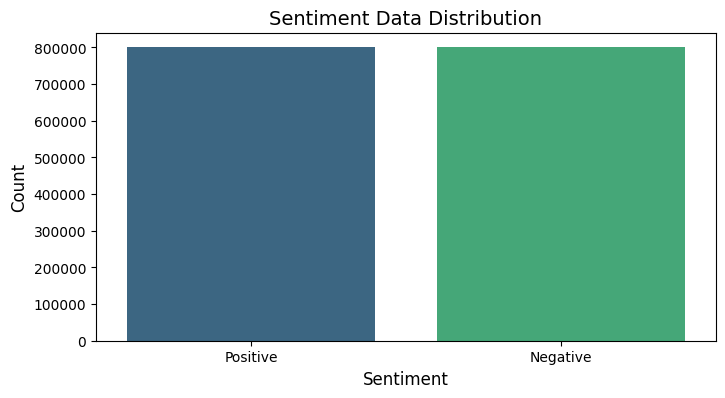

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of each sentiment category
sentiment_counts = df1['sentiment'].value_counts()

# Set the figure size
plt.figure(figsize=(8,4))

# Use seaborn barplot for better visualization
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")

# Set title and labels
plt.title("Sentiment Data Distribution", fontsize=14)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Show the plot
plt.show()



The top 10 users who have tweeted the most have been identified by counting the occurrences of user_id in the dataset. We then visualizes the results using a bar chart.

<Axes: >

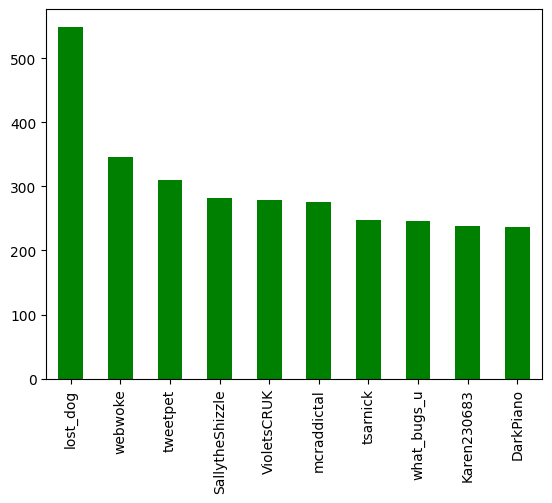

In [0]:
#users who tweet the most
users = df1['user_id'].value_counts()[:10]
users.plot(kind='bar', color='green')

We wanted to analyze the most frequently occurring words in tweets. Without any data processing, the most common words would all be stepwords. Therefore, the text is split into individual words, then stop words are removed and word occurrences counted. The top 50 most common words are then visualized using a bar chart.

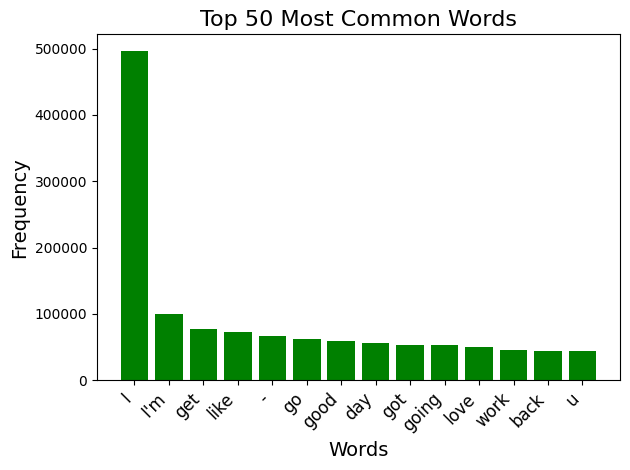

In [0]:
#most commonly occuring words
corpus = []
stop_words = stopwords.words('english')

word = df1['text'].str.split()
new = word.values.tolist()
corpus = [word for i in new for word in i]

counter = Counter(corpus)
most = counter.most_common(100)

x, y = [], []
for word, count in most[:50]:
    # Can avoid stop words too
    if word not in stop_words:
        x.append(word)
        y.append(count)

plt.bar(x, y, color='green')


# Improve x-axis label readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Add labels and title
plt.xlabel("Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Top 50 Most Common Words", fontsize=16)

# Adjust layout to prevent overlapping
plt.tight_layout()

plt.show()

This is a treemap visualization of the most common words in tweets, it is a clearer alternative to the bar plot above. The word frequency data is converted into a Pandas DataFrame (temp). Then, using plotly.express (px), we created a treemap where the size of each section represents the frequency of a word.

In [0]:
temp = pd.DataFrame(most)


fig = px.treemap(temp, path=[0], values=1,title='Tree of Most Common Tweeted words')
fig.show()

Finally, we built the histogram of the distribution of tweet lengths in the dataset, using .str.len(). We can see that most tweets are between 50 and 100 words.

<Axes: >

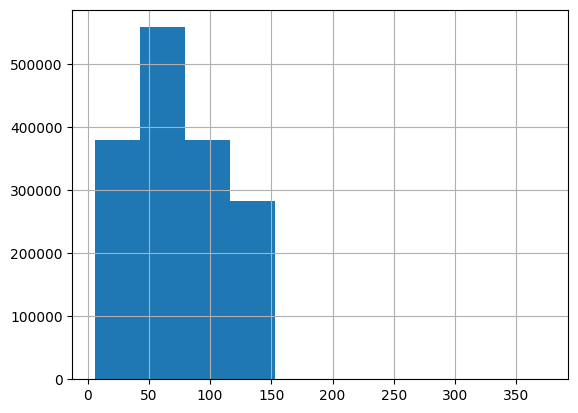

In [0]:
#lenght of the tweets
df1['text'].str.len().hist()

## Text preprocessing



The quality of data plays a crucial role in determining the performance of a machine learning model. Text data comes from natural language, so it can be unstructured and can contain noise. Preprocessing is an essential step in preparing raw textual data for Natural Language Processing (NLP) and Machine Learning (ML) tasks because poor or inconsistent data can negatively impact the model’s accuracy and overall effectiveness.

![Image](https://i.imgur.com/ZYZaTWQ.jpeg)

#### **Common Text Preprocessing Techniques**  

Text processing refers to a series of techniques used to clean and trasform raw textual data.
These are the techniques that we are going to use in this analysis:

#### 1. Lowercasing
Lowercasing is a text preprocessing step where all letters in the text are converted to lowercase so that the algorithm does not treat the same words differently in different situations.

#### 2.Removing Punctuation & Special Characters
Punctuation removal is a text preprocessing step where you remove all punctuation marks (such as periods, commas, exclamation marks, etc.) from the text to simplify it and focus on the words themselves.

#### 3.Removing Stop-Words 
Stopwords are common words present in almost all text blocks. Because they are used to building all kind of sequences, they aren't strictly linked to that sequence topic and therefore don't contribute to the meaning of a sentence in the same way. They can be removed to increase the model computational performances. More advanced models may find ways to use stopwords in a useful way, but we preferred to simply remove them.



In [0]:
stop_words = stopwords.words('english')

#### 4.Removing URLs
This preprocessing step is to remove any URLs present in the data.


#### 5.Removing Consecutive letters and short words
We decided to remove words that have less than 2 characters and 3 or more consecutive letters are replaced by 2 letters (for example, helloooo becomes helloo).


#### 6.Replacing Emojis
This is used in order to convert emojis into meaningful textual representations using a predefined dictionary that is shown below.

In [0]:
# Dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

#### 8.Stemming and Lemmatization
Stemming and Lemmatization are two text preprocessing techniques used to reduce words to their base or root form. The primary goal of these techniques is to reduce the number of unique words in a text document, making it easier to analyze and understand.
Stemming is a tecnique that involves removing suffixes from words to obtain their base form using a set of algorithms or rules, while lemmatization involves converting words to their morphological base form through more complex mathematical procedures.

Stemming is a simpler and faster technique compared to lemmatization. However, it can sometimes produce a base form that is not valid, in which case it can also lead to ambiguity.
On the other hand, lemmatization is a more sophisticated technique that uses vocabulary and morphological analysis to determine the base form of a word, that can be also found in a dictionary. But it is slower and more complex than stemming.

In our specific case, we preferred using lemmatization as it is generally considered a more accurate procedure and the time to execute the preprocessing ended up being acceptable. All of the pre-processing is done at the same time through the preprocess function, which than saves are processed text in a list.


In [0]:

def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer
    wordLemm = WordNetLemmatizer()

    # Define regex patterns for different cleaning tasks
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern = '@[^\s]+'
    alphaPattern = "[^a-zA-Z0-9]"
    sequencePattern = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    # Remove stopwords using NLTK's list of English stopwords
    stop_words = set(stopwords.words('english'))
    
    for tweet in textdata:
        # Lowercasing: Convert all text to lowercase
        tweet = tweet.lower()



        # Remove URLs (http://, https://, www.)
        tweet = re.sub(urlPattern, ' ', tweet)  
        
        # Replace emojis with a placeholder (EMOJI) followed by emoji name
        for emoji in emojis.keys():  # emojis should be a dictionary of emoji characters and their names
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        

        # Remove @USERNAME (user mentions)
        tweet = re.sub(userPattern, ' USER', tweet)
        
        # Remove punctuation and special characters, leaving only letters and numbers
        tweet = re.sub(alphaPattern, " ", tweet)
        
        # Remove consecutive letters (e.g., 'heeeelllooo' -> 'heello')
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        
        # Remove stopwords, while keeping words longer than 1 character
        
        tweetwords = ''
        for word in tweet.split():
            if word not in stop_words and len(word) > 1:  # Exclude words of length 1 (like 'a', 'I')
                # Apply lemmatization
                word = wordLemm.lemmatize(word)  # Lemmatization: reducing to base form (e.g., 'running' -> 'run')
                #word = ps.stem(word)  # Stemming: reducing to root form (e.g., 'running' -> 'run')
                tweetwords += (word + ' ')
        
        processedText.append(tweetwords)
    
    return processedText #SE VOGLIAMO AVERE UNA LISTA
    #return " ".join(processedText)  #UNICA STRINGA SEPARATA DA SPAZIO

In [0]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/spark-3e612e64-b20b-4418-8750-e2/nltk_data...


True

In [0]:
# Storing data in lists.
text, sentiment = list(df1['text']), list(df1['sentiment'])


import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 174 seconds


We decided to compute again some EDA section graphs to see how they have improved thanks to the text preprocessing.

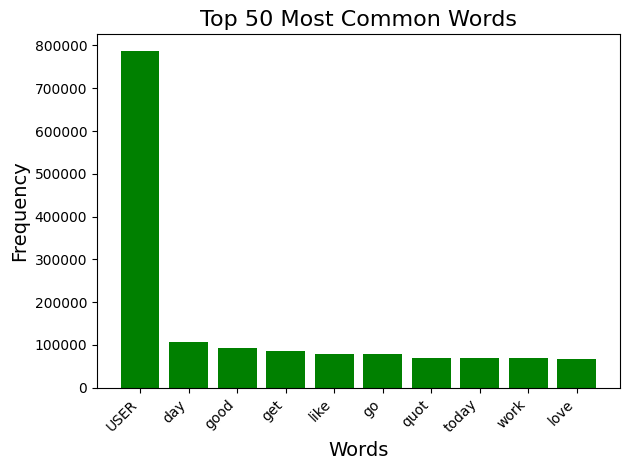

In [0]:
corpus = []
for tweet in processedtext:
    corpus.extend(tweet.split())

# Count the most common words
counter = Counter(corpus)
most1 = counter.most_common(100)

# Extract words and their counts (excluding stop words)
x, y = [], []
for word, count in most1[:10]:
    if word not in stop_words:
        x.append(word)
        y.append(count)

# Plotting the top 50 most common words
plt.bar(x, y, color='green')

# Improve x-axis label readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Add labels and title
plt.xlabel("Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Top 50 Most Common Words", fontsize=16)

# Adjust layout to prevent overlapping
plt.tight_layout()

plt.show()

In [0]:
temp = pd.DataFrame(most1)


fig = px.treemap(temp, path=[0], values=1,title='Tree of Most Common Tweeted words')
fig.show()

The processed text is filtered based on sentiment labels, separating positive and negative sentiments. Two word clouds are generated: one for negative sentiment and another for positive sentiment. These word clouds display the most frequently occurring words within each sentiment category.

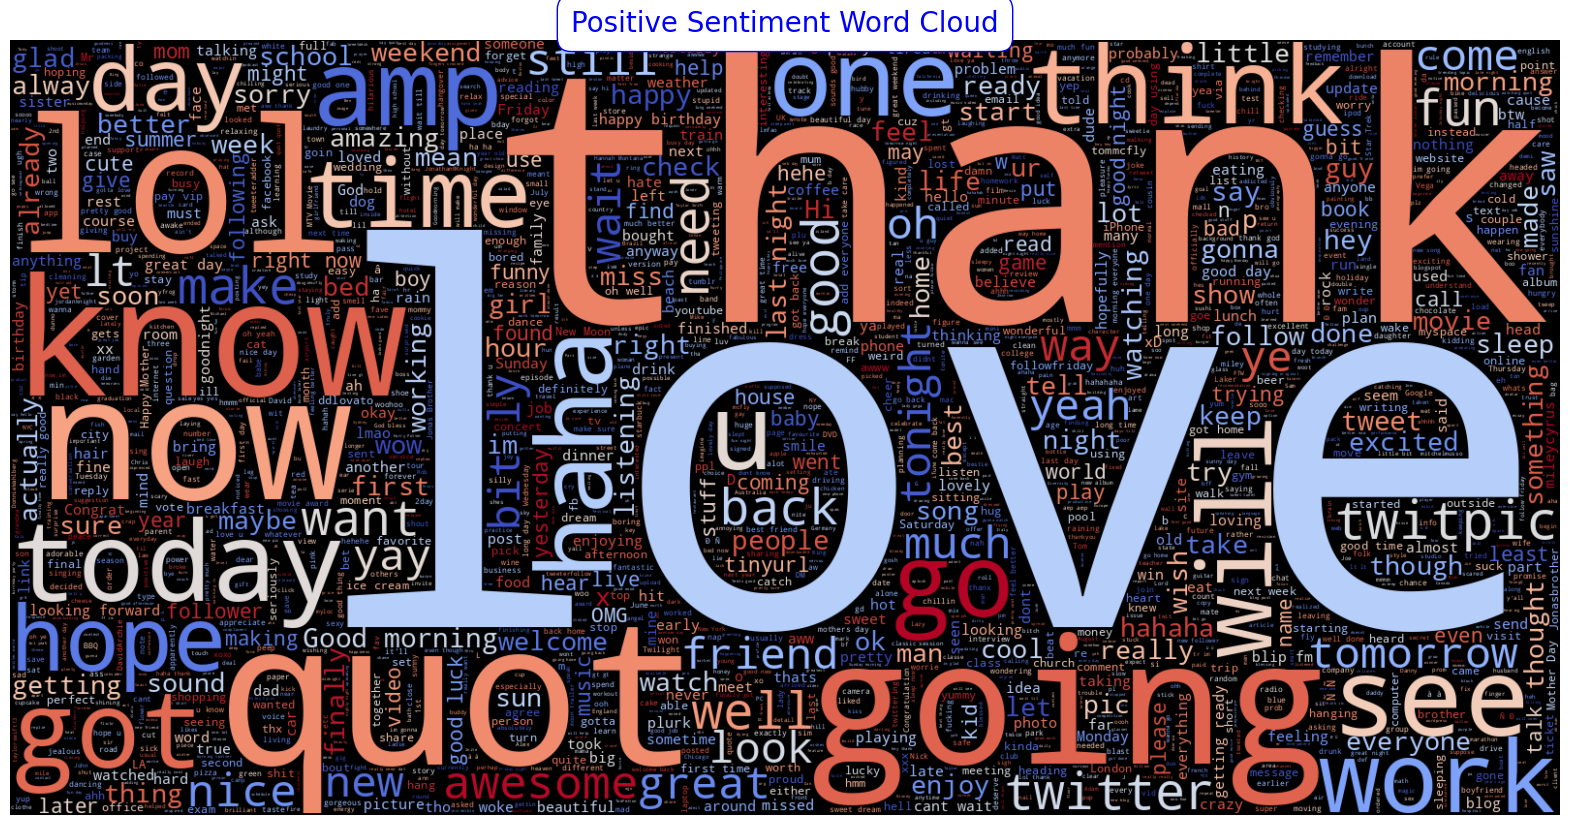

In [0]:
plt.figure(figsize=(20, 20))
wc = WordCloud(
    max_words=2000,
    width=1600,
    height=800,
    colormap="coolwarm",
    background_color="black",
    contour_color="white",
    contour_width=2
).generate(" ".join(df1[df1.sentiment == 'Positive'].text))

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Positive Sentiment Word Cloud", fontsize=20, color="blue",
          bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.5'))
plt.show()

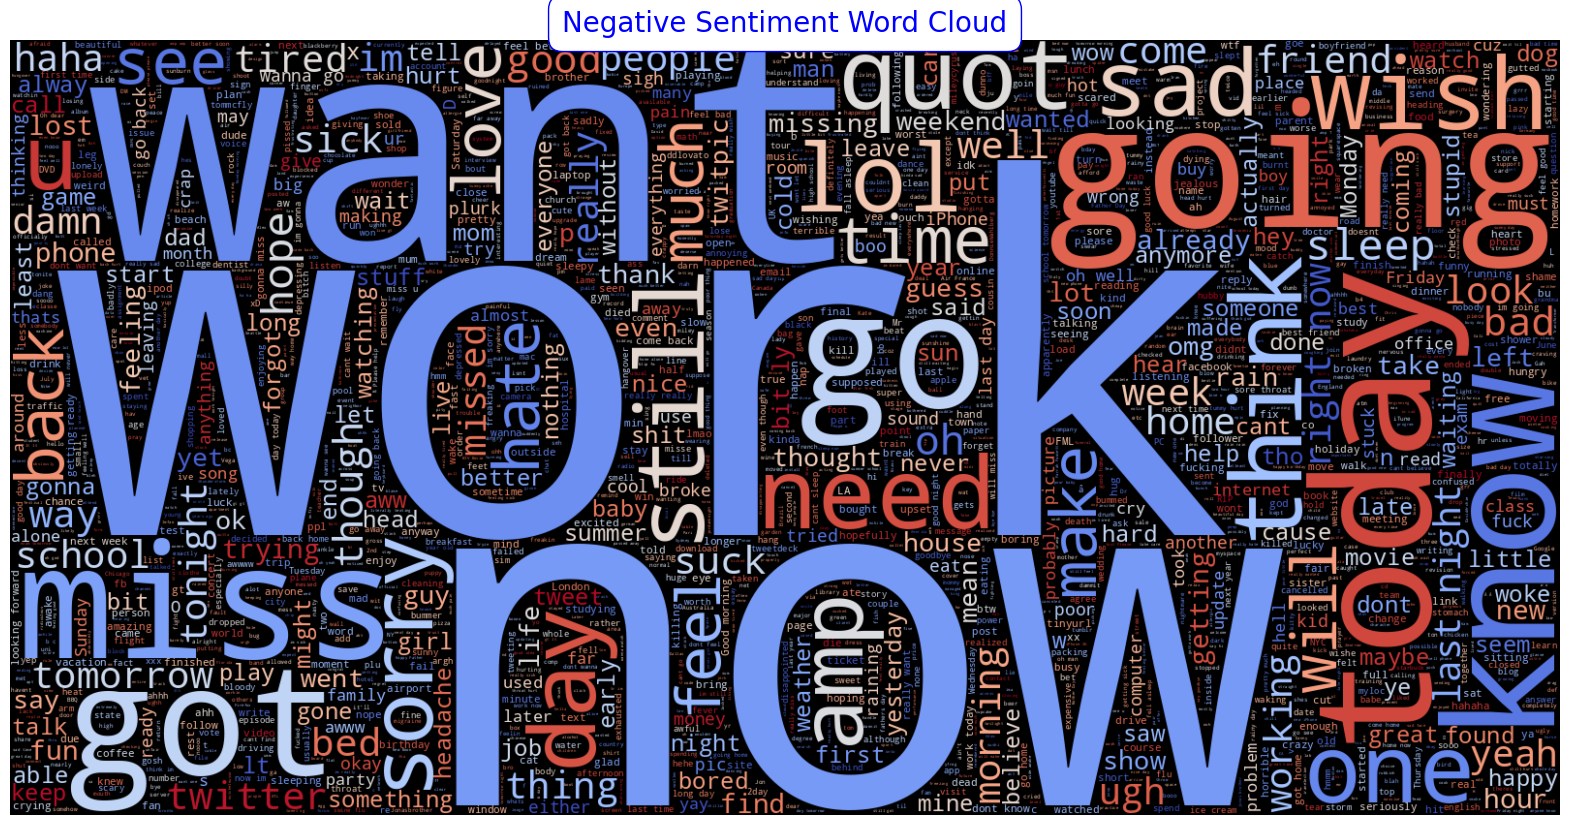

In [0]:
plt.figure(figsize=(20, 20))  
wc = WordCloud(
    max_words=2000, 
    width=1600, 
    height=800, 
    colormap="coolwarm",  
    background_color="black",  
    contour_color="white",  
    contour_width=2  
).generate(" ".join(df1[df1.sentiment == 'Negative'].text))

plt.imshow(wc, interpolation='bilinear')  
plt.axis("off")  
plt.title("Negative Sentiment Word Cloud", fontsize=20, color="blue",
          bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.5'))
plt.show()

Beside sentiment analysis, we also tried to perform community detection on the data set. To do this, we extract the user mentions from the tweets. This is needed to build a graph of the interactions between users, in which users are nodes and mentions of users are represented by the edges. Each node is weighted on the base of the number of mentions of that user. To avoid making the task too computationally intensive, we selected a subset of the data made up of 10.000 tweets and limited our analysis to this data set.

In [0]:
#Extracting mentions from tweets
def extract_mentions(text):
    mentions = re.findall(r'@(\w+)', text)
    return mentions

df1['mentions'] = df1['text'].apply(extract_mentions)

#Creating a directed graph of user interactions
G = nx.Graph()

#Sampling a subset to avoid excessively long computations
sample_df = df1.sample(10000, random_state=42)

for _, row in sample_df.iterrows():
    source = row['user_id']
    mentions = row['mentions']
    if mentions:
        for target in mentions:
            if G.has_edge(source, target):
                G[source][target]['weight'] += 1
            else:
                G.add_edge(source, target, weight=1)

## Data Analysis

In [0]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment, test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


Word Embedding is the process of representing words through some mathematical object, for example they are often encoded in real-valued vectors. The objective is, most of the time, to obtain a representation such that semantically linked words (words with similar meaning) are close in the mathematical sense too. This allows for a different, more compact way to store texts and better efficiency of the algorithms used to analyze the text.An example of Word Embedding is TF-IDF, which stands for Term Frequency - Inverse Document Frequency. Term Frequency is a measure of the frequency of a word (term) in a document. It can be defined in various ways, for example:$$\operatorname{tf}(t, d)=\frac{f_{t, d}}{\sum_{t^{\prime} \in d} f_{t^{\prime}, d}}$$This is simply the number of times term t appears in document d divided by the total number of terms (counted with repetitions) in the document. That is the frequency of one specific word over all the words in a document. 




Inverse Document Frequency is instead a measure of the "specificity" of a word in a collection of documents. That is a value that is larger if the word appears in only 1 or a few documents, and instead smaller if it appears in many documents. A common definition is given by:$$\operatorname{idf}(t, D)=\log \frac{N}{ \mid \{d: d \in D \text { and } t \in d \} \mid}$$In this formula, N is the total number of documents while $$\mid\{\{d: d \in D \text { and } t \in d\}\}\mid$$ is the number of documents in which term t appears. This fraction is then logarithmically scaled to avoid working with very large numbers. This formula works as expected, so that if the term appears in many documents, the fraction becomes smaller and the IDF value goes to zero. Instead, if the document appears only in 1 document, the value is the biggest possible for the given number of documents.TD-IDF is just the product of this two measures, which is used because it automatically avoids giving too much importance to words that appear often, like stopwords, given that even while their TF will be high, their IDF will be zero. The IDF values are then used in our code to represent words in a matrix and this transformed data set is than used to create the training and test set for use in the classification part of the project.

In [0]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('Number of feature_words: ', len(vectoriser.get_feature_names()))

/databricks/python/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



Number of feature_words:  500000


In [0]:
#Transforming the data
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

Once the data is transformed, we defined the function that we will be using to evaluate several models: Bernoulli Naive Bayes, Linear Support Vector Classification (SVC), Logistic Regression, Classification Tree and Random Forest. The model_Evaluate function evaluates the performance of the models by predicting labels for the test dataset (X_test) and comparing them with the actual values (y_test). The aim of this function is having a complete overview of how the model works as it prints a report containing the precision, recall, F1-score and accuracy. In order to analyze the prediction errors and all the model’s strengths and weaknesses in classes, this function computes the confusion matrices, which will be visualized using Seaborn's heatmap. The fact that we can use a single compact function for all models is enabled by the similar implementation of every classifier in the scikit-learn library.

The Bernoulli Naive Bayes, the Linear SVC and the Logistic Regression are the models that performed better, with about an f1 score close to 0.8, which is about the maximum precision we hypothesized in the introduction to the data set. Between this three, the Logisitc Regression, which is also the simplest one, seems to work slightly better than the other. The other two models, the classification tree and the random forest, work less well, with f1 scores of 0.64 and 0.72 each.

In [0]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Negative','False Positive', 'False Negative','True Positive']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'coolwarm',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

**Bernoulli Model**

There are many classifiers based on the Bayes Theorem. Bernoully Naive Bayes is one example. In this case, the likelihood is assumed to follow a Bernoulli probability distribution, making it applicable to binary classification.

              precision    recall  f1-score   support

    Negative       0.79      0.77      0.78     39986
    Positive       0.77      0.80      0.78     40014

    accuracy                           0.78     80000
   macro avg       0.78      0.78      0.78     80000
weighted avg       0.78      0.78      0.78     80000



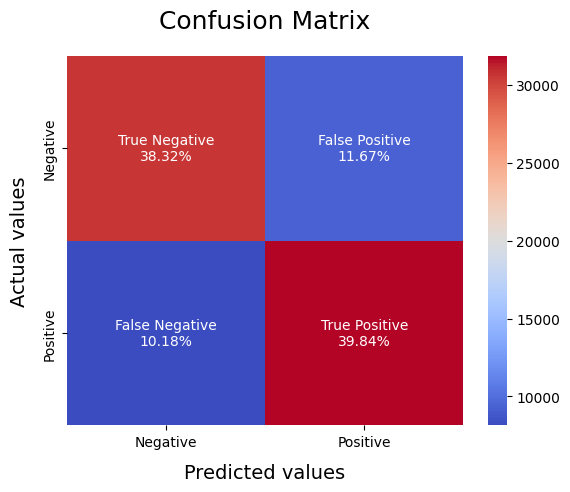

In [0]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

**LinearSVC**

Linear Support Vector Classifier is a classification technique that looks for hyperplanes in the data space to divide well defined clusters. In this case, it looks for a plane that divides negative and positive tweets in the space of the transformed data set (the one processed with the TF-IDF measure).

              precision    recall  f1-score   support

    Negative       0.79      0.77      0.78     39986
    Positive       0.78      0.80      0.79     40014

    accuracy                           0.78     80000
   macro avg       0.78      0.78      0.78     80000
weighted avg       0.78      0.78      0.78     80000



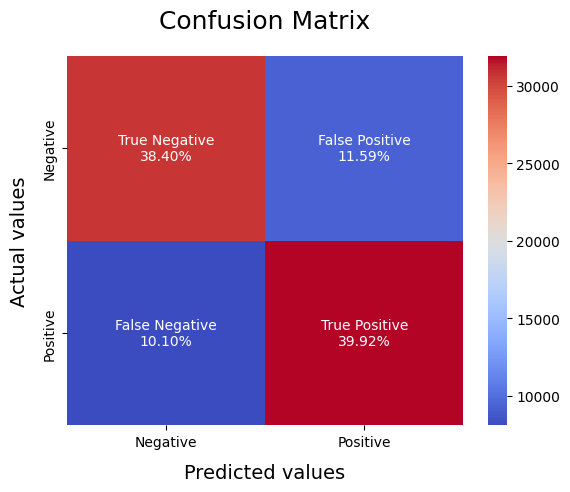

In [0]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

**Logistic Regression**

Logistic Regression is one of the simplest classification algorithm that has been invented. It works by calculating what is knows as the logit function on the data after having fitted it's coefficients properly. After having selected a threshold level, for example 0.5, the result of the calculation with the logit can be used to classify a certain element in one of the available classes, in our case either negative or positive.

              precision    recall  f1-score   support

    Negative       0.81      0.78      0.79     39986
    Positive       0.79      0.81      0.80     40014

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



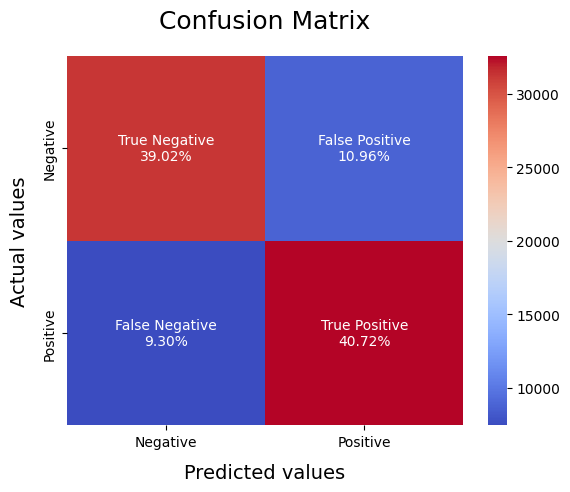

In [0]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

**Classification Tree**

Tree based classification methods are non-parametrics classification techniques based on a gerarchical structure that remembers trees. This methods are quite simple while having the advantage of being able to deal with complex non-linear relationships in the data set.

              precision    recall  f1-score   support

    Negative       0.64      0.67      0.65     39986
    Positive       0.65      0.62      0.64     40014

    accuracy                           0.64     80000
   macro avg       0.65      0.64      0.64     80000
weighted avg       0.65      0.64      0.64     80000



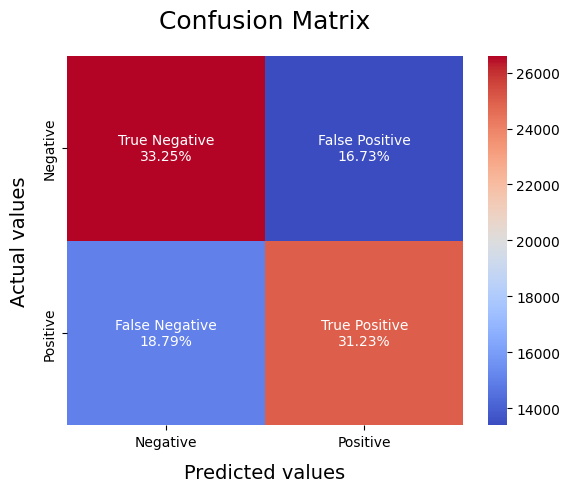

In [0]:
ClassificationTree = DecisionTreeClassifier(max_depth = 15)
ClassificationTree.fit(X_train, y_train)
model_Evaluate(ClassificationTree)

**Random Forest**

Random Forest is an ensamble method which takes advantage of resampling techniques to improve tree based algorithms performances. This improvement comes at the cost of interpretability of the results, which is way easier with simple trees. Also, ensamble techniques are notoriously computationally expensive. Luckily, in our case the algorithm doesn't take too much time to execute.


              precision    recall  f1-score   support

    Negative       0.70      0.73      0.71     39986
    Positive       0.72      0.68      0.70     40014

    accuracy                           0.71     80000
   macro avg       0.71      0.71      0.71     80000
weighted avg       0.71      0.71      0.71     80000



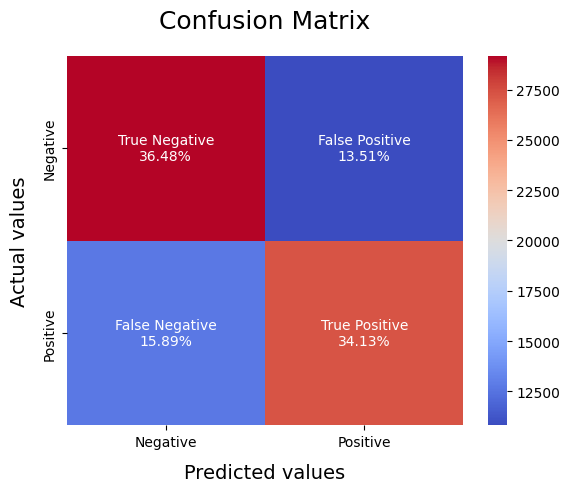

In [0]:
RandomForest = RandomForestClassifier(n_estimators = 100, max_depth = 15)
RandomForest.fit(X_train, y_train)
model_Evaluate(RandomForest)

## Use of the model

We wanted to see how the model trained would work on different sample texts. In order to do that, the pre-trained model and a vectorizer are loaded, which is used to convert the text into a format the model can understand. Then, it takes a list of sentences, analyzes their sentiment, and labels them as either “Positive” or “Negative.” This quick test shows that, on simple texts, the model seems to work as expected, correctly assigning the positive and negative label.

Before doing that, these three objects (a text vectorizer and two sentiment analysis models) have been saved using Python’s pickle module. Each object is written to a separate binary file, allowing it to be reloaded later for sentiment prediction. 

In [0]:
with open('vectoriser-ngram-(1,2).pickle', 'wb') as file:
    pickle.dump(vectoriser, file)

with open('Sentiment-LR.pickle', 'wb') as file:
    pickle.dump(LRmodel, file)

with open('Sentiment-BNB.pickle', 'wb') as file:
    pickle.dump(BNBmodel, file)


In [0]:
def load_models():
    #loads the vectorizer and Sentiment Analysis model.
    
    with open('vectoriser-ngram-(1,2).pickle', 'rb') as f:
        vectoriser = pickle.load(f)
    with open('Sentiment-LR.pickle', 'rb') as f:
        model = pickle.load(f)
    return vectoriser, model

def predict_sentiment(vectoriser, model, texts):
    #predicts the sentiment of a list of texts.
   
    text_data = vectoriser.transform(texts)
    sentiments = model.predict(text_data)
    results = pd.DataFrame({'text': texts, 'sentiment': sentiments})
    results = results.replace([0, 1], ["Negative", "Positive"])
    return results

if __name__ == "__main__":
    vectoriser, model = load_models()
    sample_texts = ["I love this product!", "This is the worst experience ever.", 
                    "So happy with my new phone! ",
                    "Terrible experience.I will never buy from here.",
                     "Just had the best coffee ever. Highly recommend this place! ", 
                    "This update ruined the app. Nothing works anymore."]
    results = predict_sentiment(vectoriser, model, sample_texts)
    print(results)


                                                text sentiment
0                               I love this product!  Positive
1                 This is the worst experience ever.  Negative
2                       So happy with my new phone!   Positive
3    Terrible experience.I will never buy from here.  Negative
4  Just had the best coffee ever. Highly recommen...  Positive
5  This update ruined the app. Nothing works anym...  Negative


## Community Detection

On the base of the graph produced in the preprocessing section, we can partition the sample in communities with the louvain algorithm. After having identified the communities, we add a new column to the original dataset specifying the community of the users belonging to our sample (others are marked by "-1").

In [0]:
#Detecting communities using Louvain algorithm
partition = community_louvain.best_partition(G)

#Adding community labels to original dataframe
def get_community(user_id):
    return partition.get(user_id, -1)  # -1 for users not in sampled graph

df1['community'] = df1['user_id'].apply(get_community)

To obtain a sense of the result, we can visualize the largest communities found by the algorithm through a bar plot (>50 members) and label them on the base of the prevailing sentiment of the members tweets (positive or negative). Also, we can make a map of the communities and their connections. We can see that most communities found are made up of a mixed bag of negative and positive tweets; about these we can't really say much a priori. Instead, there are some communities which are mostly negative or positive, we can assume that these communities where linked by a specific topic about which nearly all users had either a positive or negative attitude, showing a clear cut opinion on that item. From our simple analysis it isn't however possible to retrieve the specific subject of those communities.

<Figure size 1400x800 with 0 Axes>

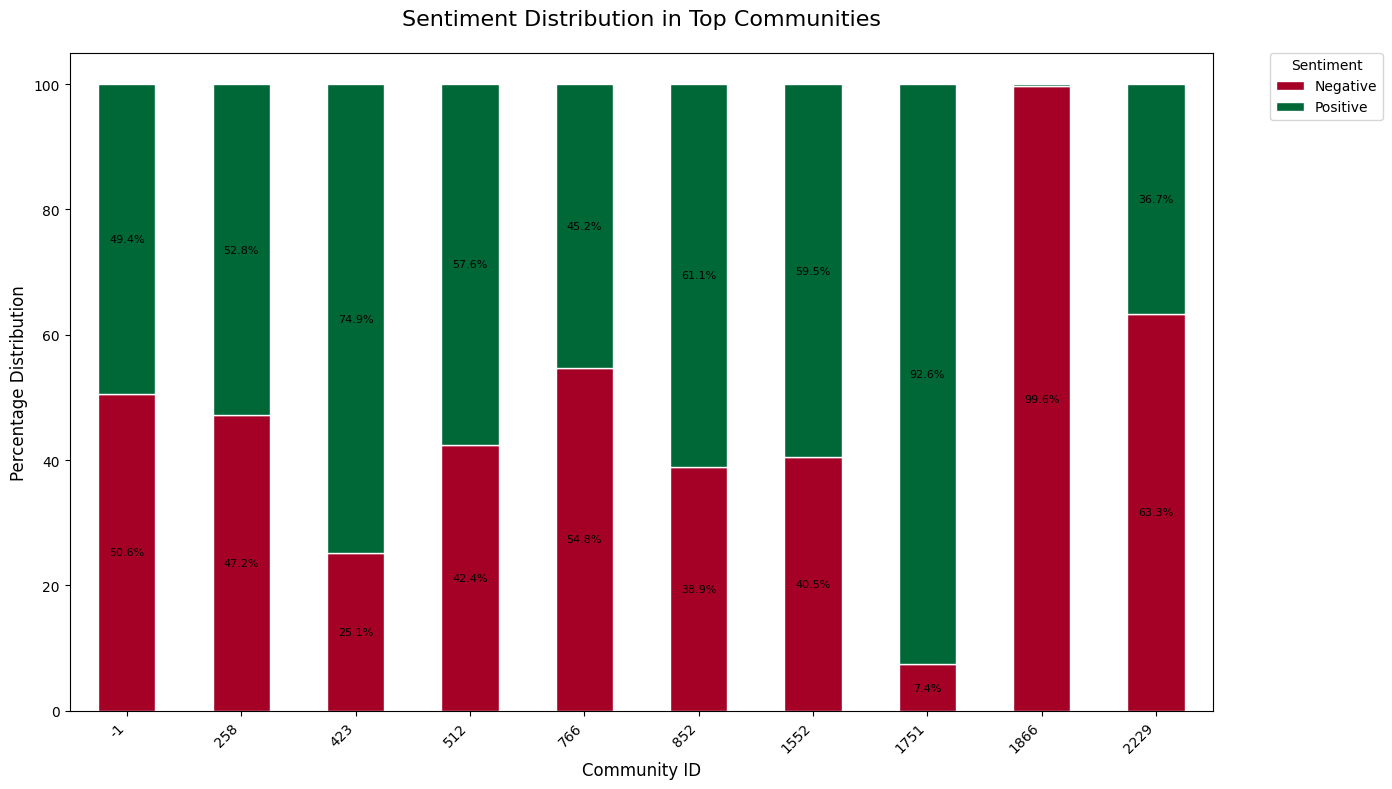

In [0]:
# Modified sentiment distribution plot
plt.figure(figsize=(14, 8))

# Get top 10 communities by size
comm_counts = df1['community'].value_counts(); top_comms = comm_counts[comm_counts > 50].index.tolist()[:10]
filtered_df = df1[df1['community'].isin(top_comms)]

# Create percentage stacked bar plot
comm_sentiment = filtered_df.groupby(['community', 'sentiment']).size().unstack()
comm_sentiment = comm_sentiment.div(comm_sentiment.sum(axis=1), axis=0) * 100

ax = comm_sentiment.plot(kind='bar', stacked=True, colormap='RdYlGn', figsize=(14, 8), edgecolor='w')

plt.title('Sentiment Distribution in Top Communities', fontsize=16, pad=20)
plt.xlabel('Community ID', fontsize=12)
plt.ylabel('Percentage Distribution', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Add percentage labels
for bar in ax.patches:
    width = bar.get_width()
    height = bar.get_height()
    x, y = bar.get_xy()
    if height > 5:  # Only label segments >5%
        ax.text(x + width/2, y + height/2, f'{height:.1f}%', ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()

Finally, we added another visualization to show the shape of some of a pair of the communities found, just to show an example of the job made by the algorithm and check what kind of structures are built. Generally, there are a few nodes that are highly mentioned and therefore are linked by a large number of edges to other nodes, with other smaller clusters linked in a more or less complicated way.

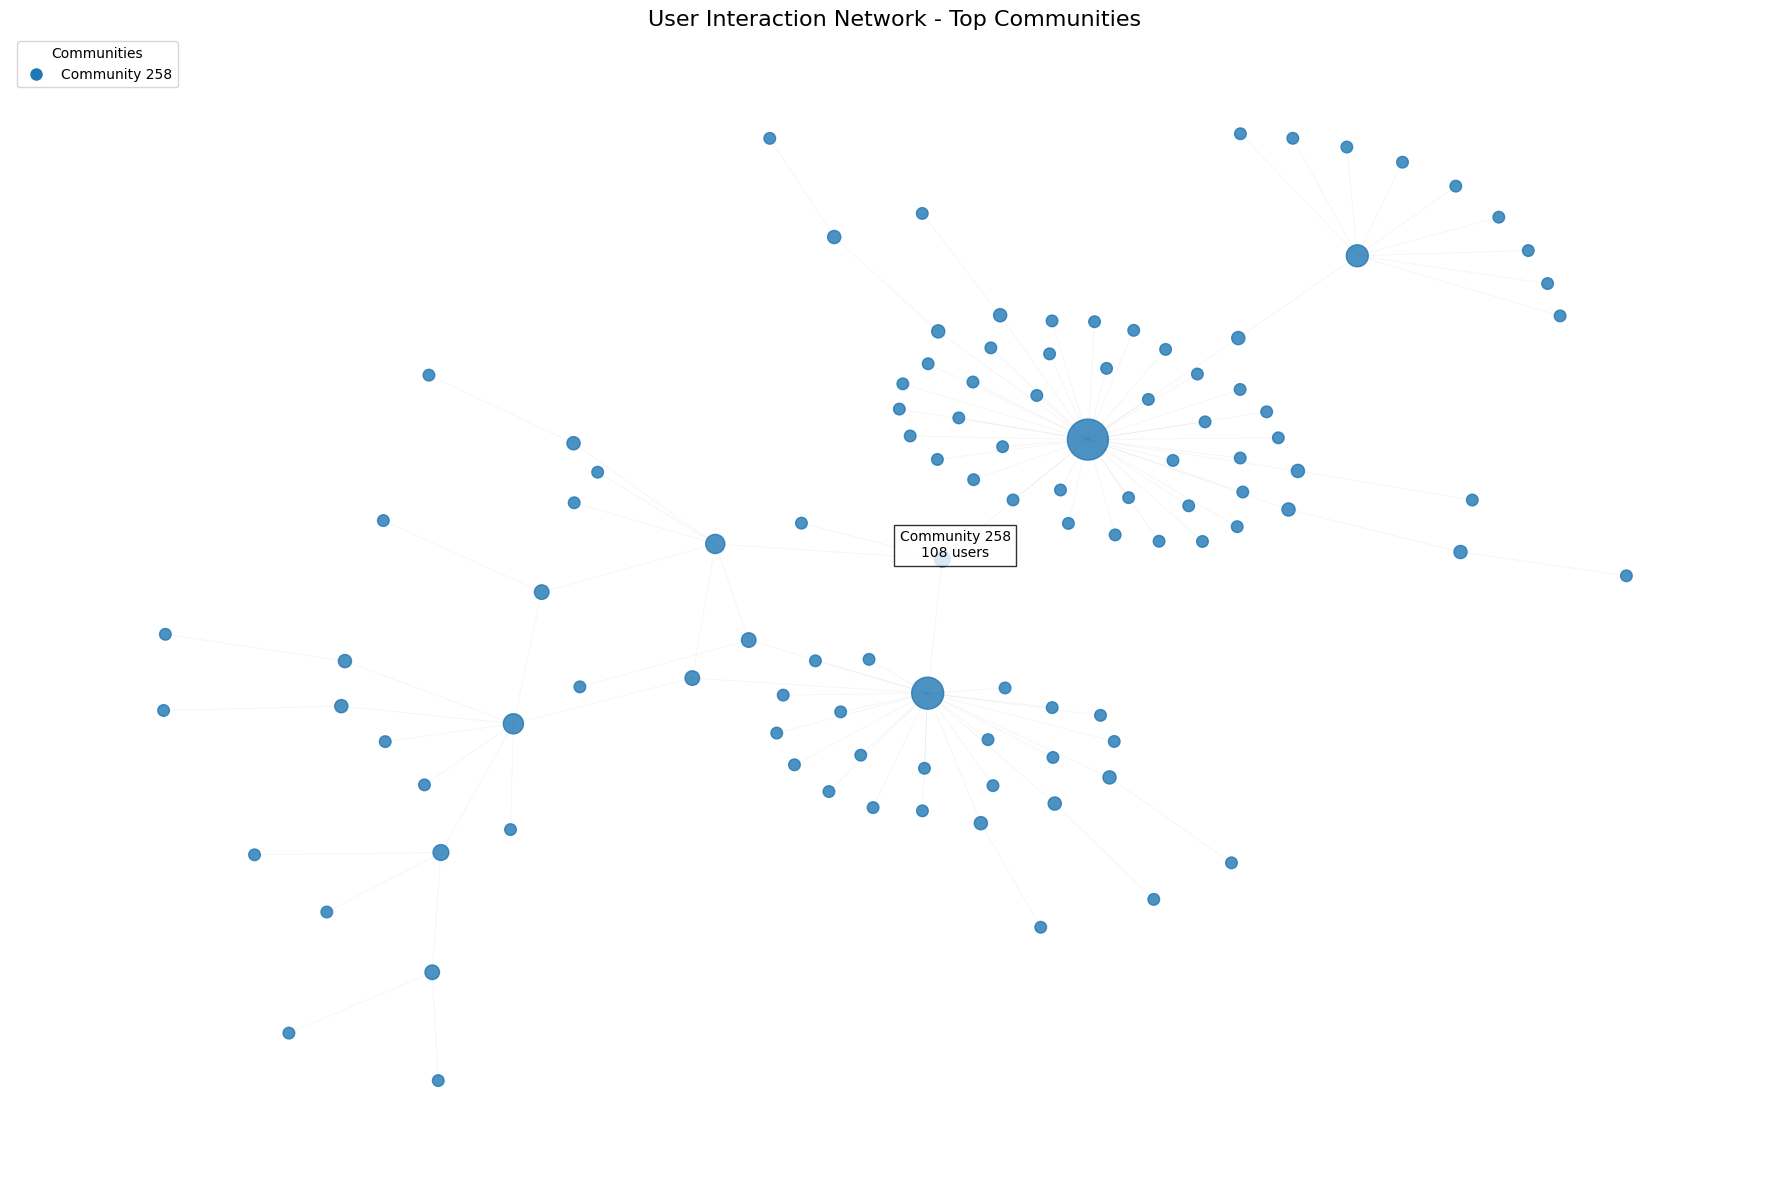

In [0]:
# Enhanced network visualization
plt.figure(figsize=(18, 12))

# Create subgraph of top communities
top_communities = [c for c in np.unique(list(partition.values())) if list(partition.values()).count(c) > 50][:5]

# Get nodes from top communities
top_nodes = [n for n in G.nodes() if partition.get(n, -1) in top_communities]
subgraph = G.subgraph(top_nodes)

# Calculate layout and visual properties
pos = nx.kamada_kawai_layout(subgraph)
community_colors = {c: f'C{i}' for i, c in enumerate(top_communities)}
node_colors = [community_colors[partition[n]] for n in subgraph.nodes()]
degrees = dict(nx.degree(subgraph))
node_sizes = [50 + degrees[n]*20 for n in subgraph.nodes()]

# Draw network
nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)

nx.draw_networkx_edges(subgraph, pos, width=0.5, alpha=0.1, edge_color='gray')

# Add labels for community centers
for comm in top_communities:
    comm_nodes = [n for n in subgraph.nodes() if partition[n] == comm]
    x_mean = np.mean([pos[n][0] for n in comm_nodes])
    y_mean = np.mean([pos[n][1] for n in comm_nodes])
    plt.text(x_mean, y_mean, f'Community {comm}\n{len(comm_nodes)} users', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))

# Create legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f'Community {c}', markerfacecolor=community_colors[c], markersize=10) for c in top_communities]

plt.legend(handles=legend_elements, loc='upper left', title="Communities")

plt.title('User Interaction Network - Top Communities', fontsize=16)
plt.box(False)
plt.tight_layout()
plt.show()